# Imports

In [511]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML

#metricas
import sklearn.metrics
import scikitplot        as skplt
from scipy import stats

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

#modelos
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from imblearn.ensemble       import BalancedRandomForestClassifier
from boruta                  import BorutaPy
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import linear_model as lm
from sklearn.naive_bayes     import GaussianNB
import xgboost                                   as xgb


## Helper functions

In [512]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [513]:
import warnings
warnings.filterwarnings("ignore")

In [514]:
def precision_at_k( data, k=200 ):
    """
    Object that return the precision at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the precision at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=200 ):
    """
    Object that return the recall at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the recall at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def performace(model_name, data, y_val, yhat_class, k=200):
    """

    :param model_name: string, with the name of the algoritm that will be used
    :param data: dataframe sorted by  probabilit given to each iten by the model
    :param y_val: list of the target variable of the dataframe
    :param yhat_class: binary prediction made by the model for each iten
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val, yhat_class,average='macro')
    recal = sklearn.metrics.recall_score(y_val, yhat_class,average='macro')
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_val, yhat_class)
    recal_k = recall_at_k(data, k)
    prec_k = precision_at_k(data, k)

    return pd.DataFrame({'Model Name': model_name,
                         'Precison': prec,
                         'Recall': recal,
                         'Balanced_acc': balanced_acc,
                         'k': k,
                         'Precison at k': prec_k,
                         'Recall at k': recal_k}, index=[0])



In [515]:
def performace_cross_val(data, target, model, model_name, round_n=4, splits=3, shuffle_n=True, random=42, k=200):
    """
    this cross-validation object uses kfold with stratified folds and return the metrics
    :param data: dataframe
    :param target: string, name of the target variable
    :param model: model that will be used
    :param model_name: string with the model name
    :param round_n: int, default=5number of decimal points of the float values that will be returned
    :param splits: int, default=5, number of folds
    :param shuffle_n:bool, default=True, Whether to shuffle each class’s samples before splitting into batches
    :param random: int, default=42 controls the randomness of each fold
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the mean and standard deviation of the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'id'])
    precision = []
    recall = []
    balan_acc = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index].values.ravel())

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:, 1].tolist()

        # sorte by score
        aux = aux.sort_values('score', ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux, k))
        rec_k.append(recall_at_k(aux, k))

    # return a dataset with the metrics
    return pd.DataFrame({'model name': model_name + " CV",
                        'precision_cv': np.round(np.mean(precision), round_n),
                        'prec_std': np.round(np.std(precision), round_n),
                        'recall_cv': np.round(np.mean(recall), round_n),
                        'rec_std': np.round(np.std(recall), round_n),
                        'balanced_acc_cv': np.round(np.mean(balan_acc), round_n),
                        'bal_std': np.round(np.std(balan_acc), round_n),
                        'k': k,
                        'precision_at_k_cv': np.round(np.mean(prec_k), round_n),
                        'perc_k_std': np.round(np.std(prec_k), round_n),
                        'recall_at_k_cv': np.round(np.mean(rec_k), round_n),
                        'rec_k_std': np.round(np.std(rec_k))}, index=[0])




# 1.0 Load data 

In [516]:
path_local = 'C:/Users/Lavin/Documents/desafios/ifood/'
df6 = pd.read_csv(path_local + 'data/processed/df5.csv')

## Split train and test

In [517]:
train, val = train_test_split(df6,test_size=0.33, random_state=42,stratify=df6['response'])

In [518]:
# train.to_csv(path_local + 'src/data/df_train.csv',index=False)
# val.to_csv(path_local + 'src/data/df_val.csv',index=False)

In [519]:
X_train = train.copy()
y_val = X_train['response']
X_train = X_train.drop(columns=['id','response'])

In [520]:
x_val = val.copy()
y_val = x_val['response']
x_val = x_val.drop(columns=['id','response'])

# 7.0 Machine learning

## 7.1 KNN

In [521]:
#model
knn_model = KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(X_train,y_train.values.ravel())

KNeighborsClassifier()

In [522]:
#model prediction proba - poder de generalizção
yhat_knn_proba = knn_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_knn_class = knn_model.predict( x_val )

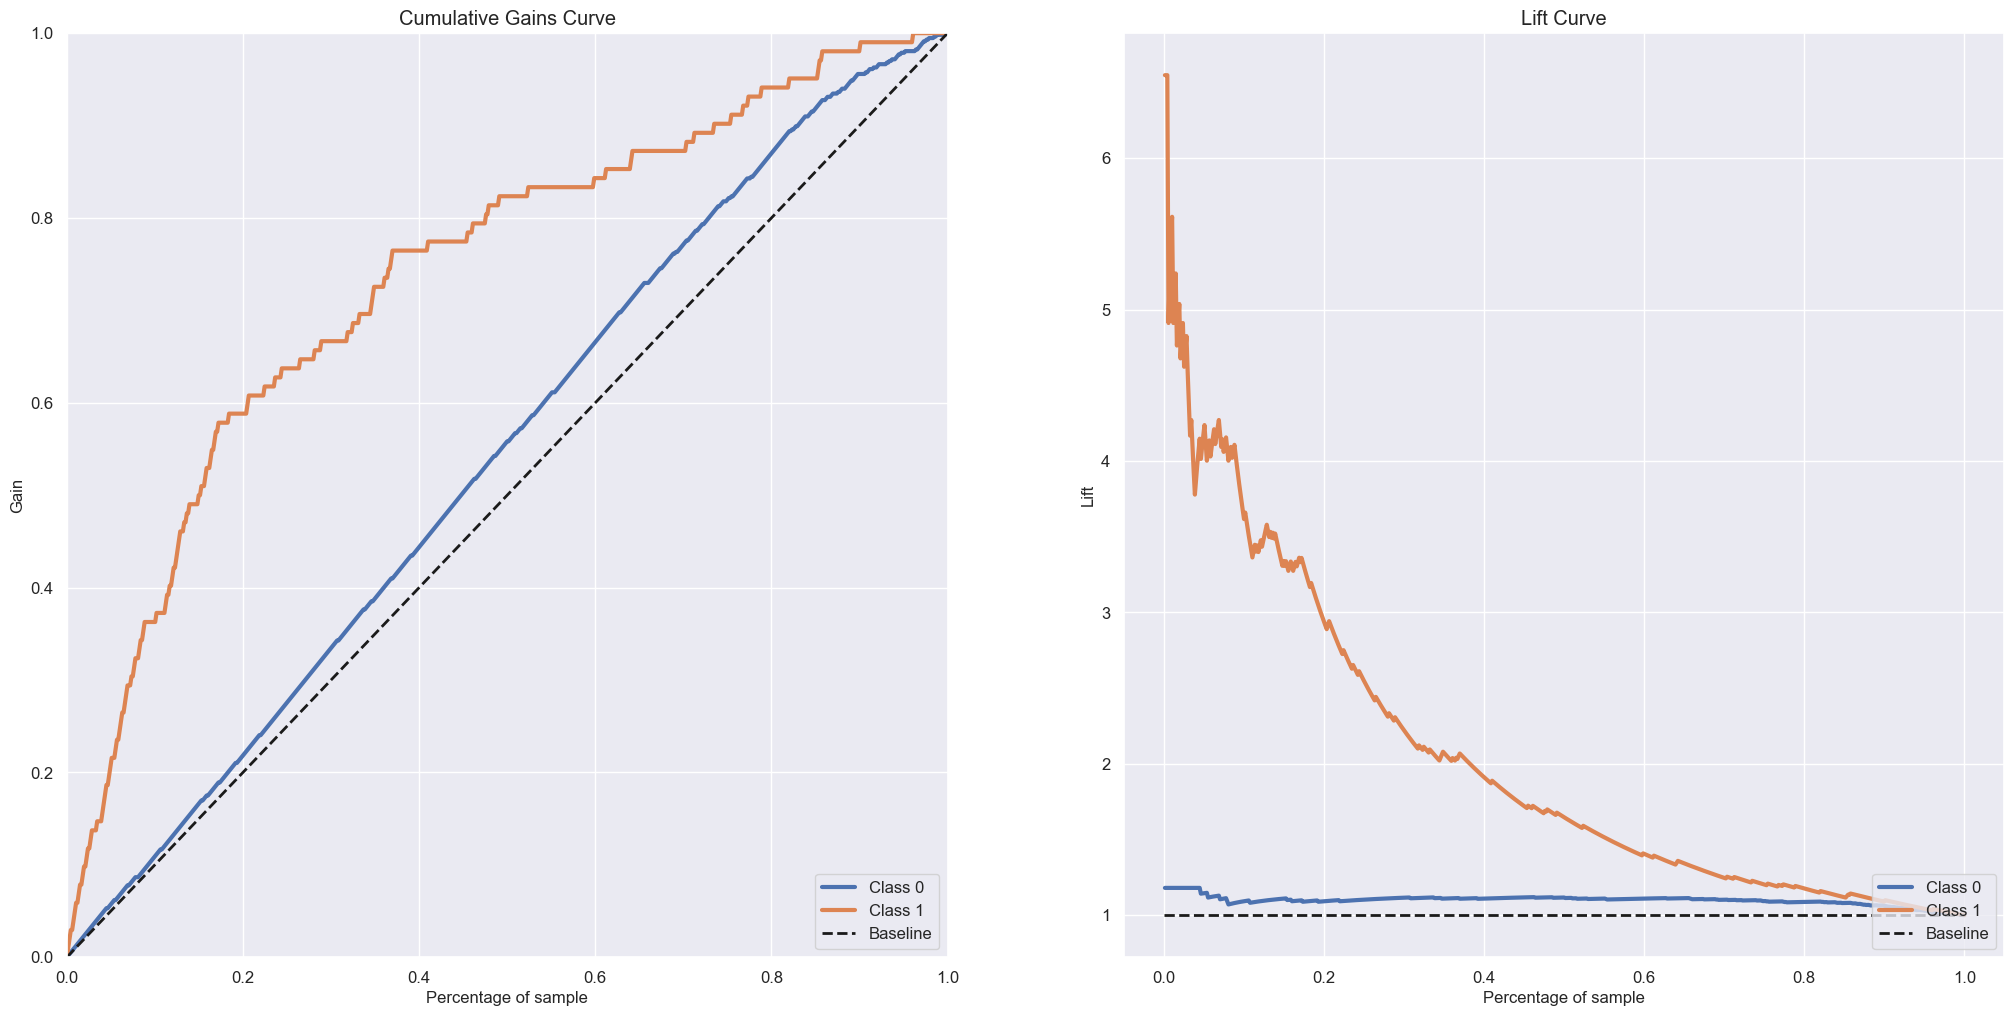

In [523]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_knn_proba,ax=ax[1]);

## 7.2 Naive bayes 

In [524]:
gnb_model = GaussianNB()

# model training
gnb_model.fit(X_train,y_train.values.ravel())

GaussianNB()

In [525]:
#model prediction proba - poder de generalizção
yhat_gnb_proba = gnb_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_gnb_class = gnb_model.predict( x_val )

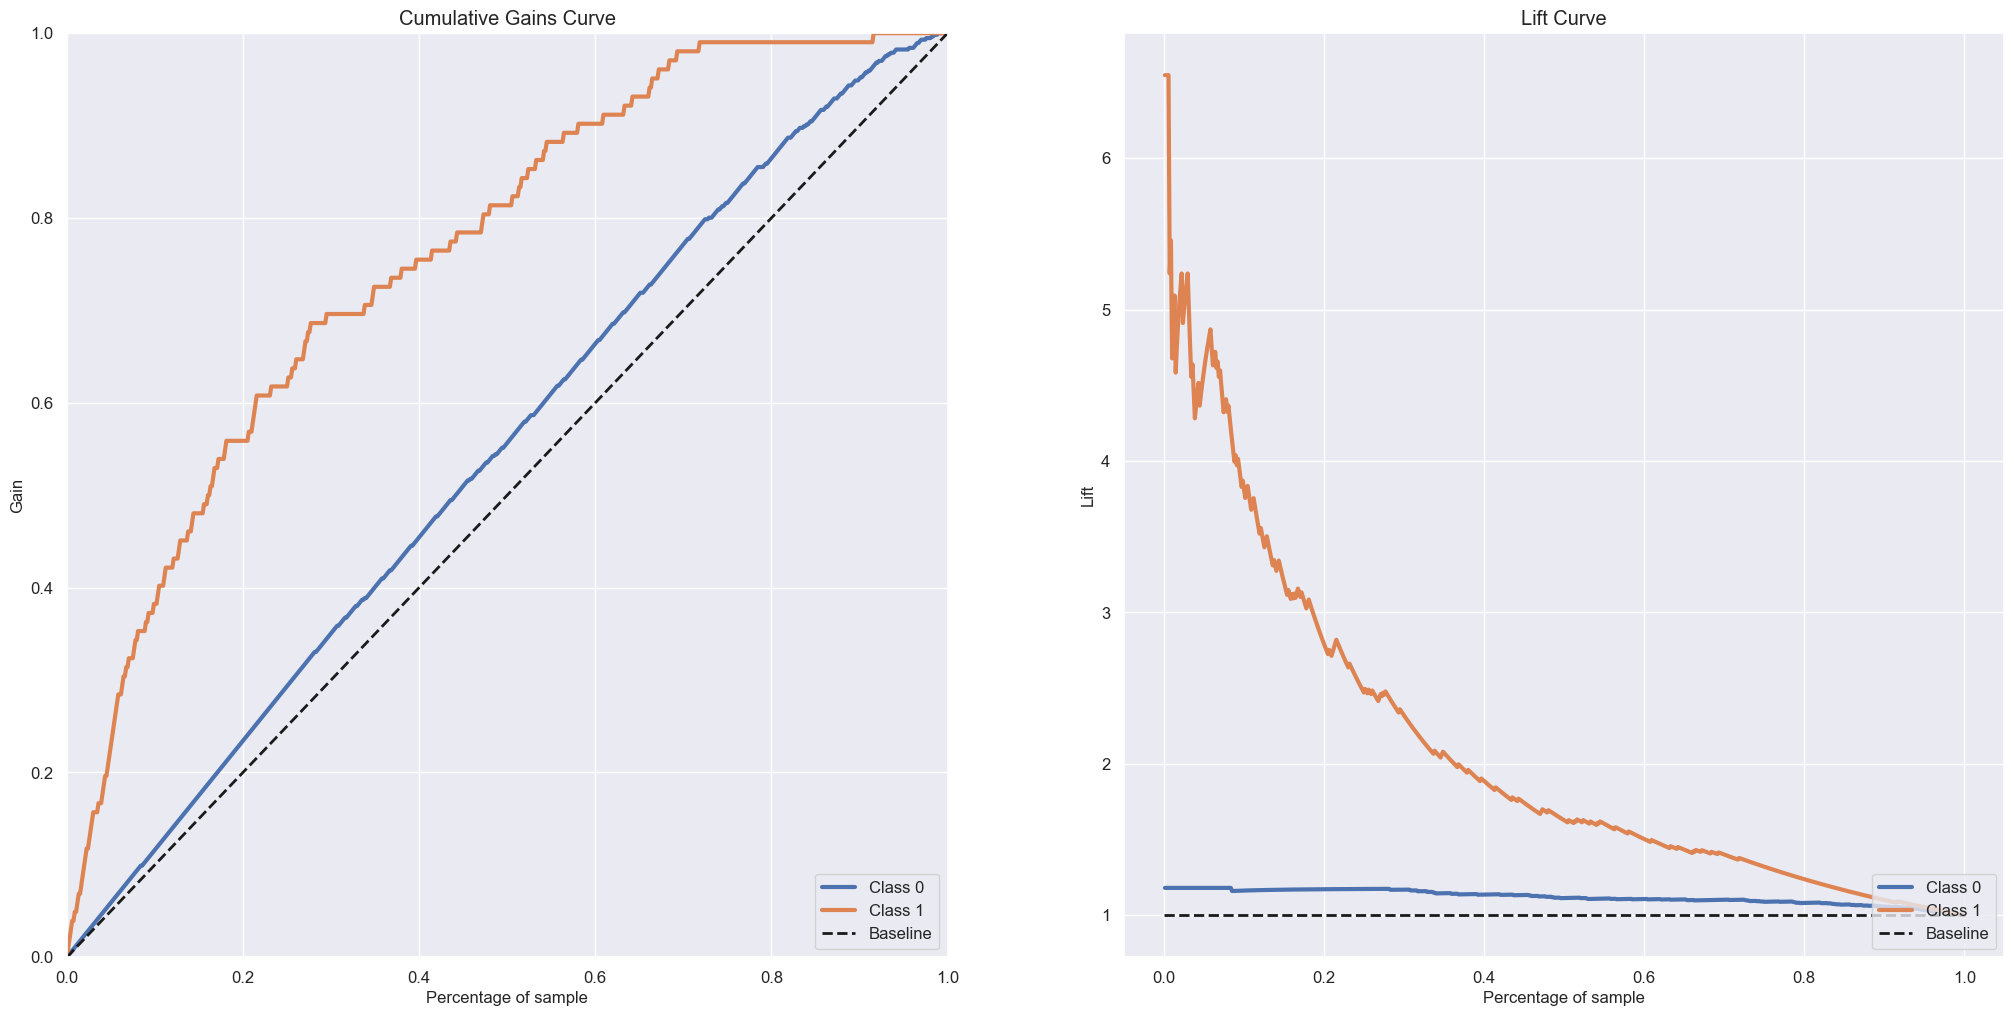

In [526]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_gnb_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_gnb_proba,ax=ax[1]);

## 7.3 Linear model

In [527]:
lm_model = lm.LogisticRegression(warm_start=True,random_state=42,n_jobs=-1)
lm_model.fit(X_train,y_train.values.ravel())

LogisticRegression(n_jobs=-1, random_state=42, warm_start=True)

In [528]:
#model prediction proba - poder de generalizção
yhat_lm_proba = lm_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_lm_class = lm_model.predict( x_val )

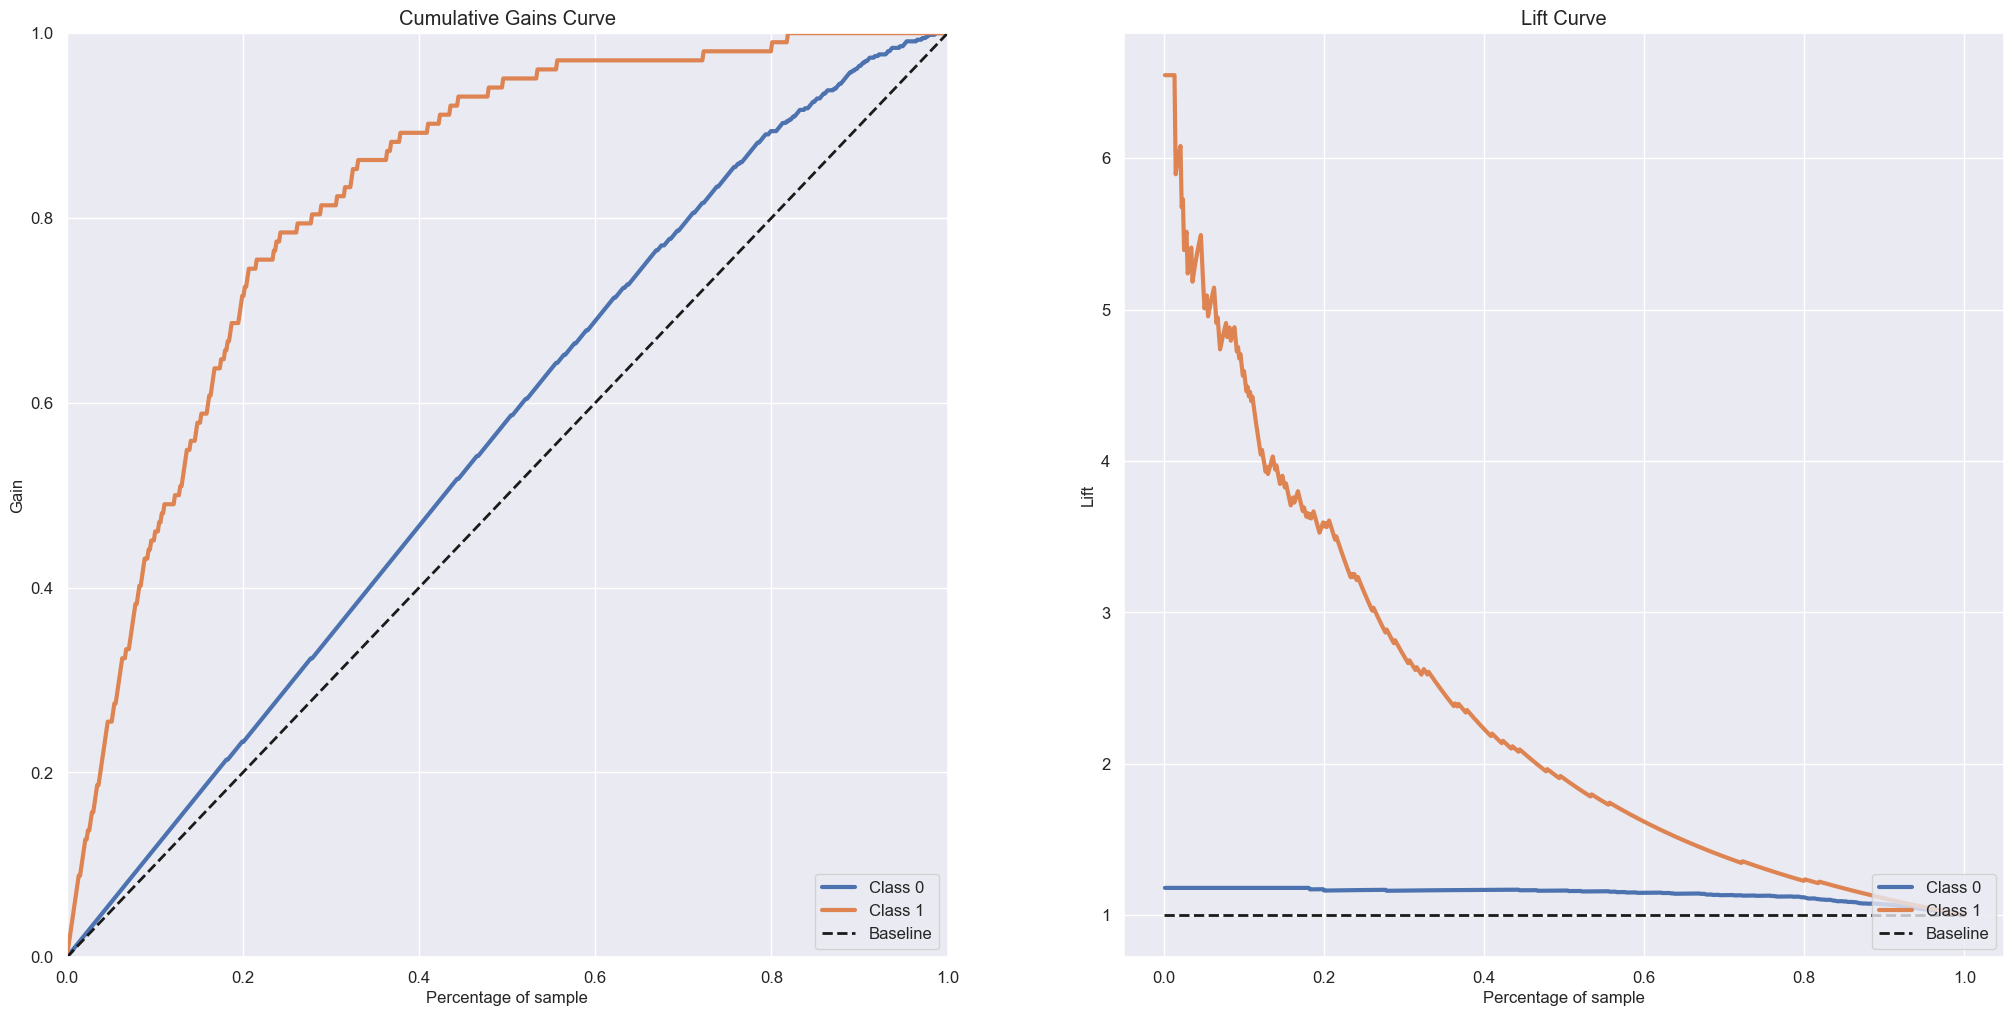

In [529]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_lm_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_lm_proba,ax=ax[1]);

## 7.4 Balanced random forest

In [530]:
brf_model = BalancedRandomForestClassifier(n_jobs=-1,random_state=42)
brf_model.fit(X_train,y_train.values.ravel())

BalancedRandomForestClassifier(n_jobs=-1, random_state=42)

In [531]:
#model prediction proba - poder de generalização
yhat_brf_proba = brf_model.predict_proba( x_val )

#model prediction - poder de generalização
yhat_brf_class = brf_model.predict( x_val )

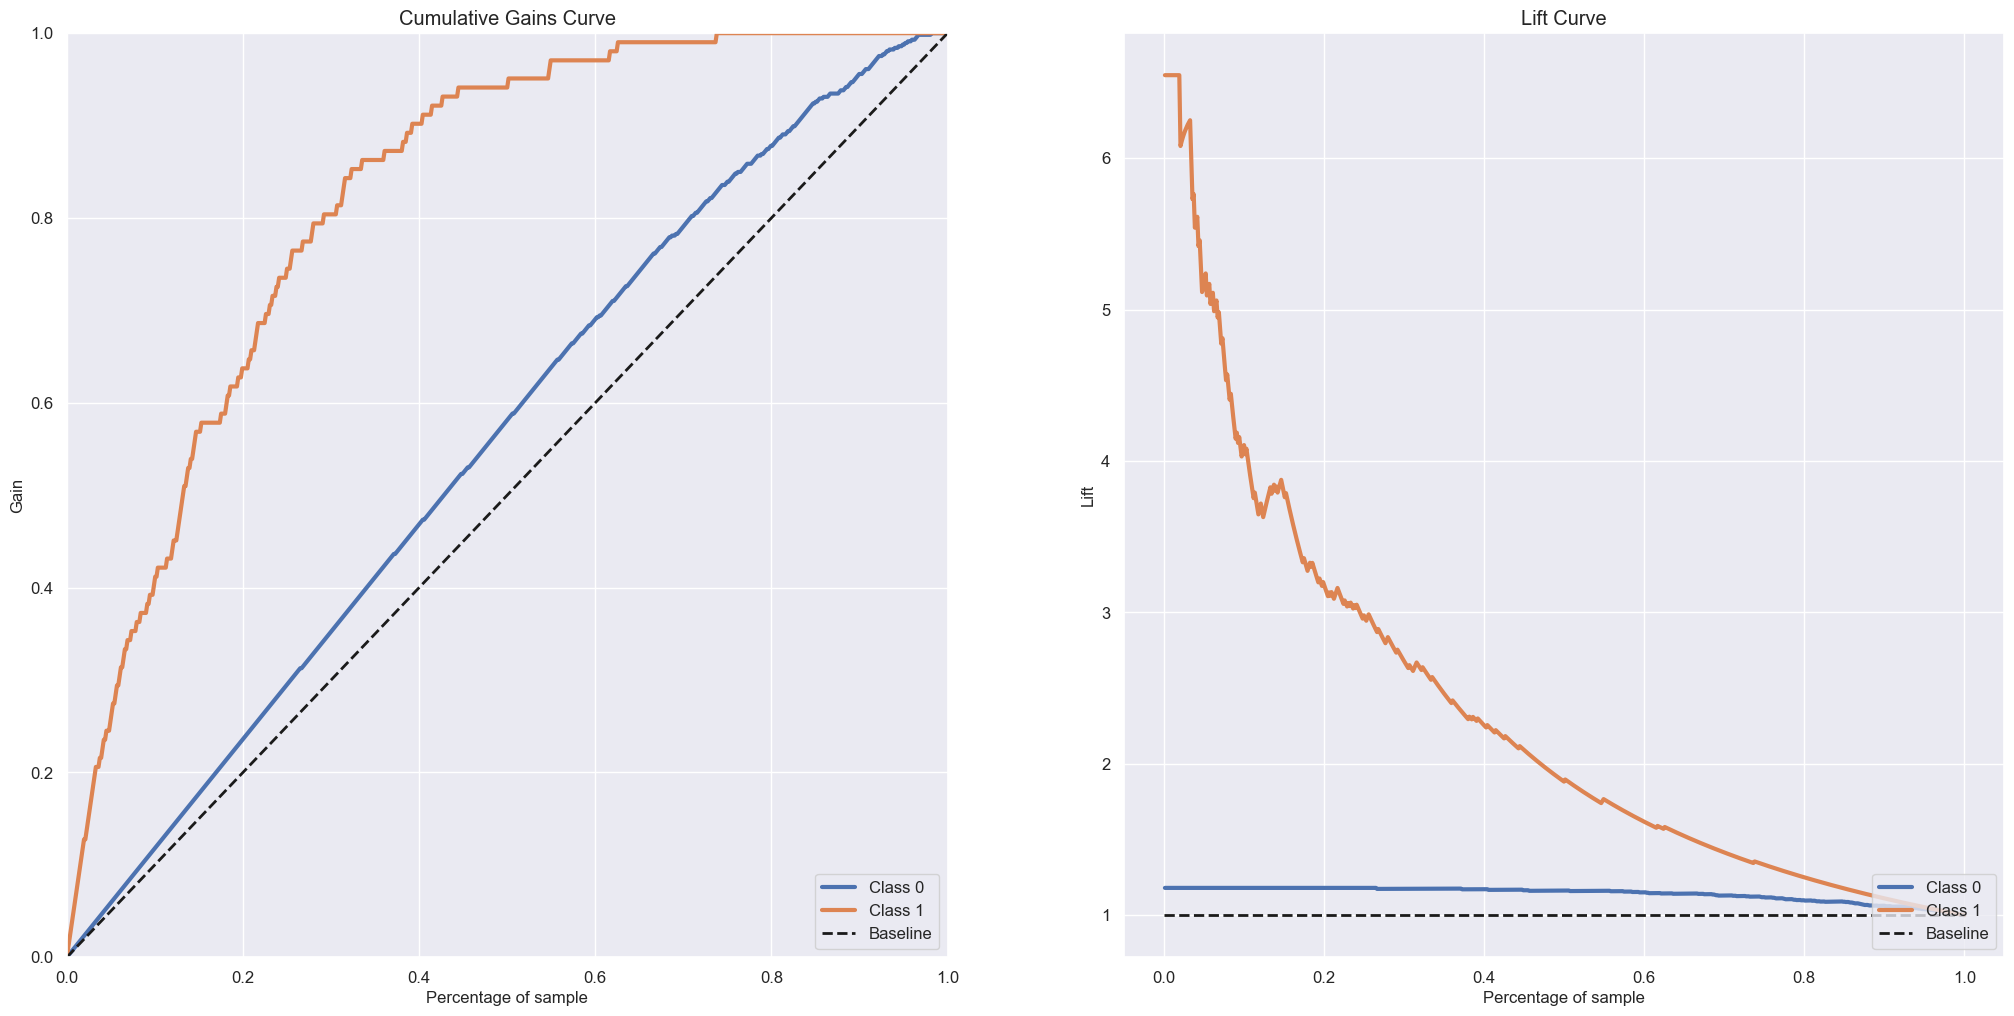

In [532]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_brf_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_brf_proba,ax=ax[1]);

## 7.5 Random forrest classifier

In [533]:
rf_model = RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1)
rf_model.fit(X_train,y_train.values.ravel())

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [534]:
#model prediction proba - poder de generalizção
yhat_rf_proba = rf_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_rf_class = rf_model.predict( x_val )

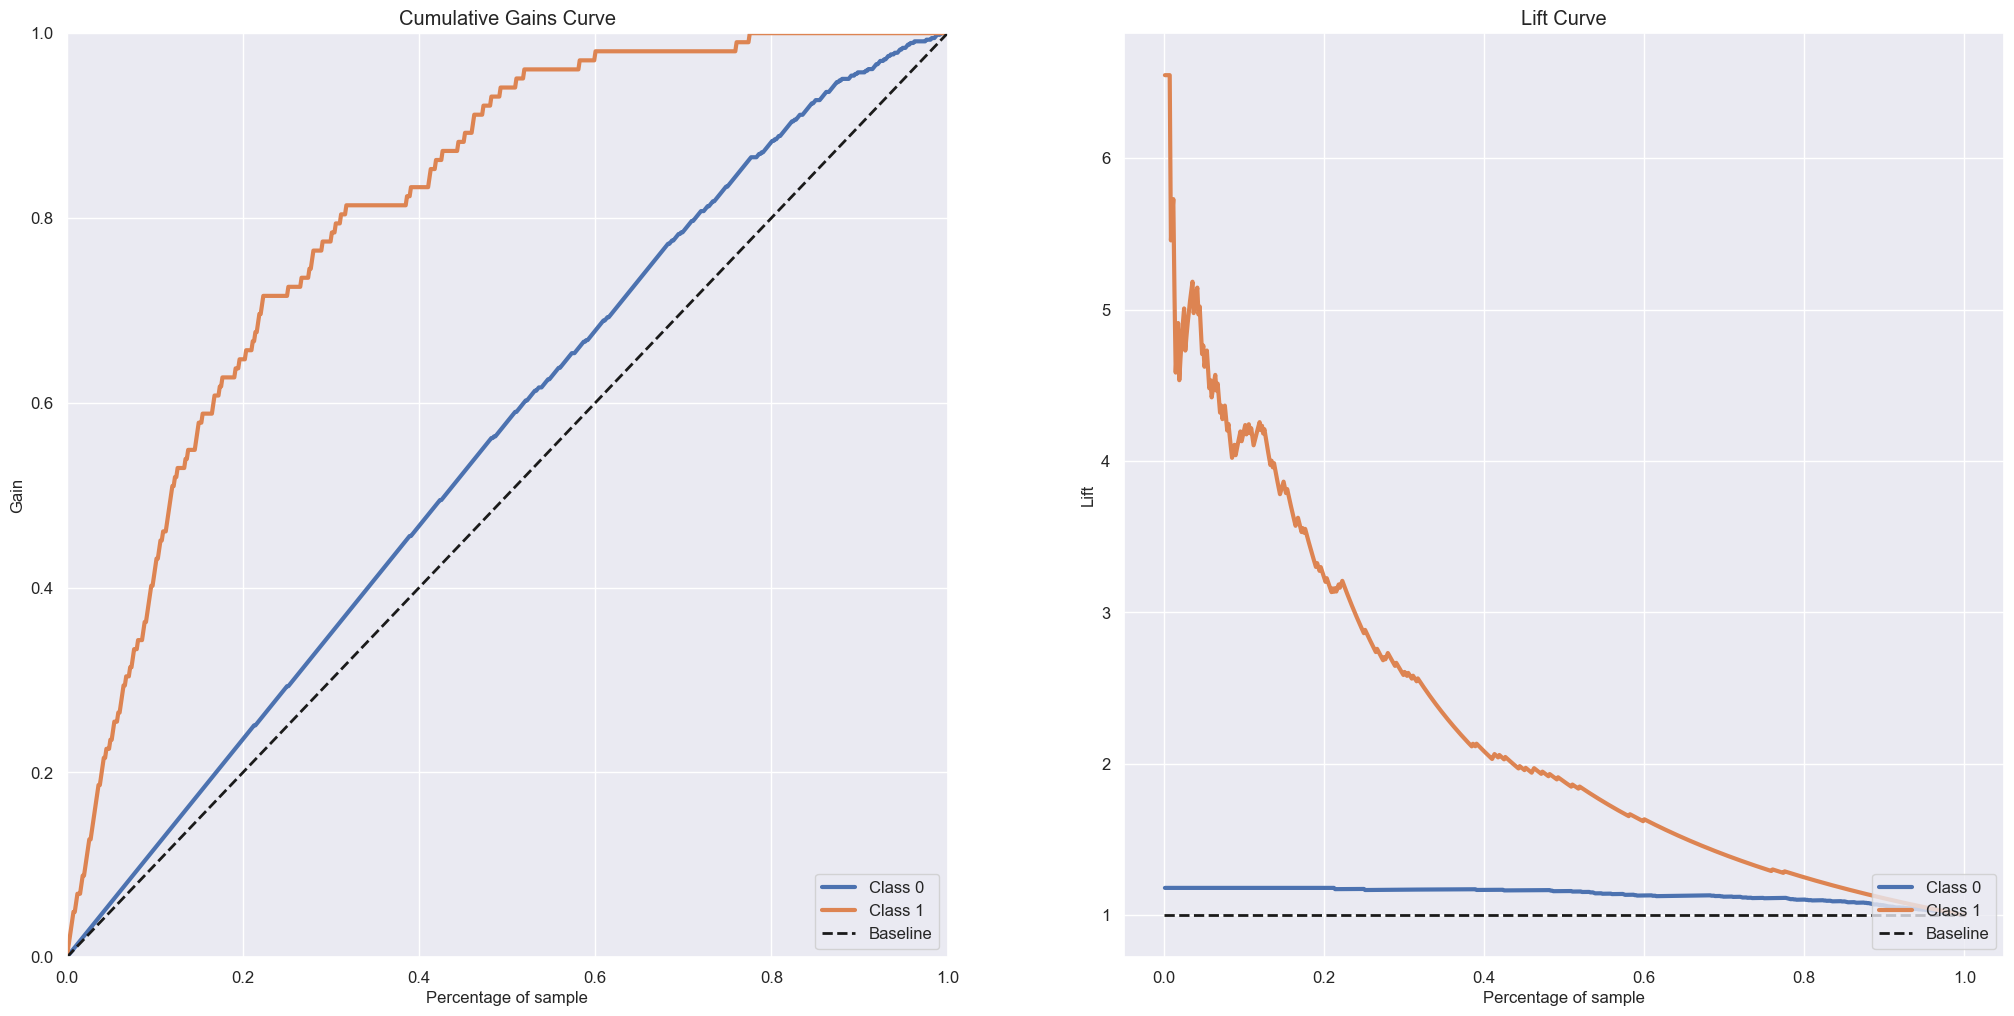

In [535]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_rf_proba,ax=ax[1]);

## 7.6 Extratree classifier

In [536]:
et_model = ExtraTreesClassifier(n_estimators=300,random_state=42,n_jobs=-1)
et_model.fit(X_train,y_train.values.ravel())

ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [537]:
#model prediction proba - poder de generalizção
yhat_et_proba = et_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_et_class = et_model.predict( x_val )

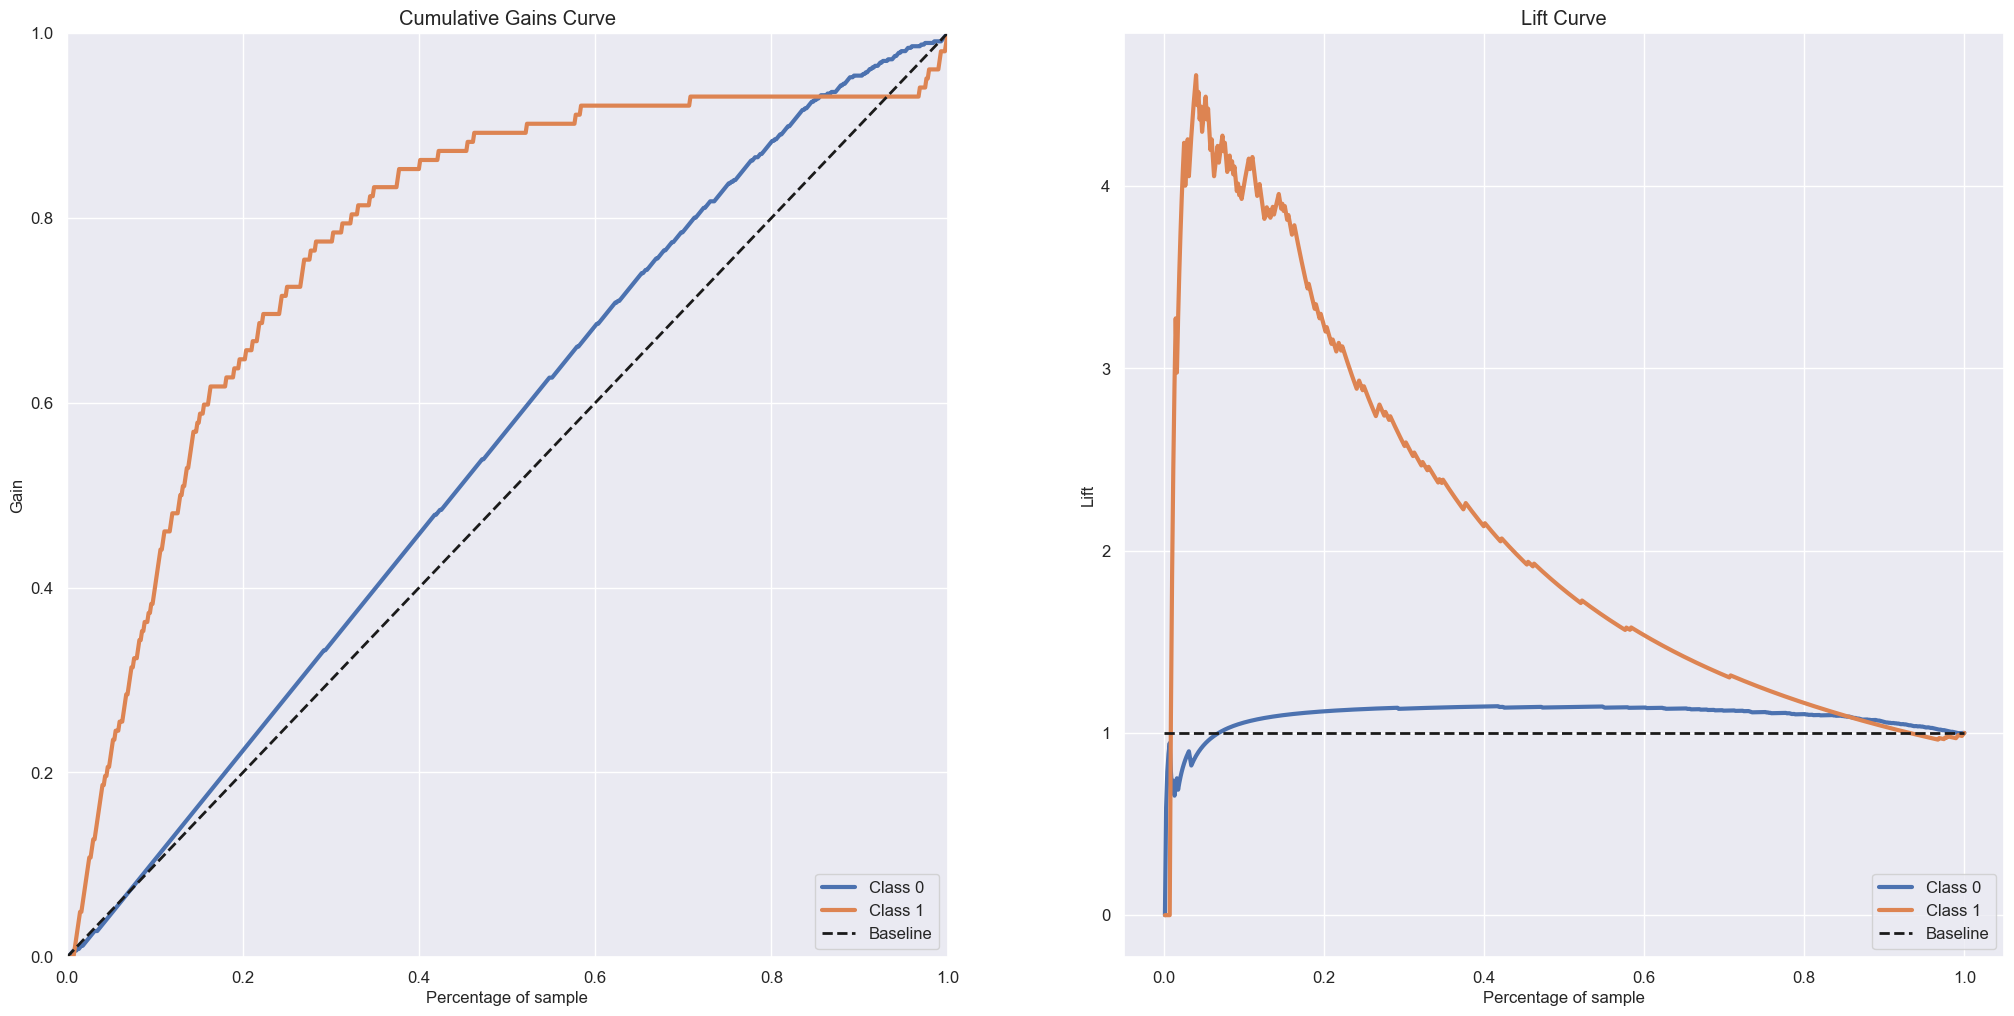

In [538]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_et_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_et_proba,ax=ax[1]);

## 7.7 XGBoost

In [539]:
xgb_model = xgb.XGBClassifier(n_estimators=300,seed=42).fit(X_train,y_train.values.ravel())

In [540]:
#model prediction proba - poder de generalizção
yhat_xgb_proba = xgb_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_xgb_class = xgb_model.predict( x_val )

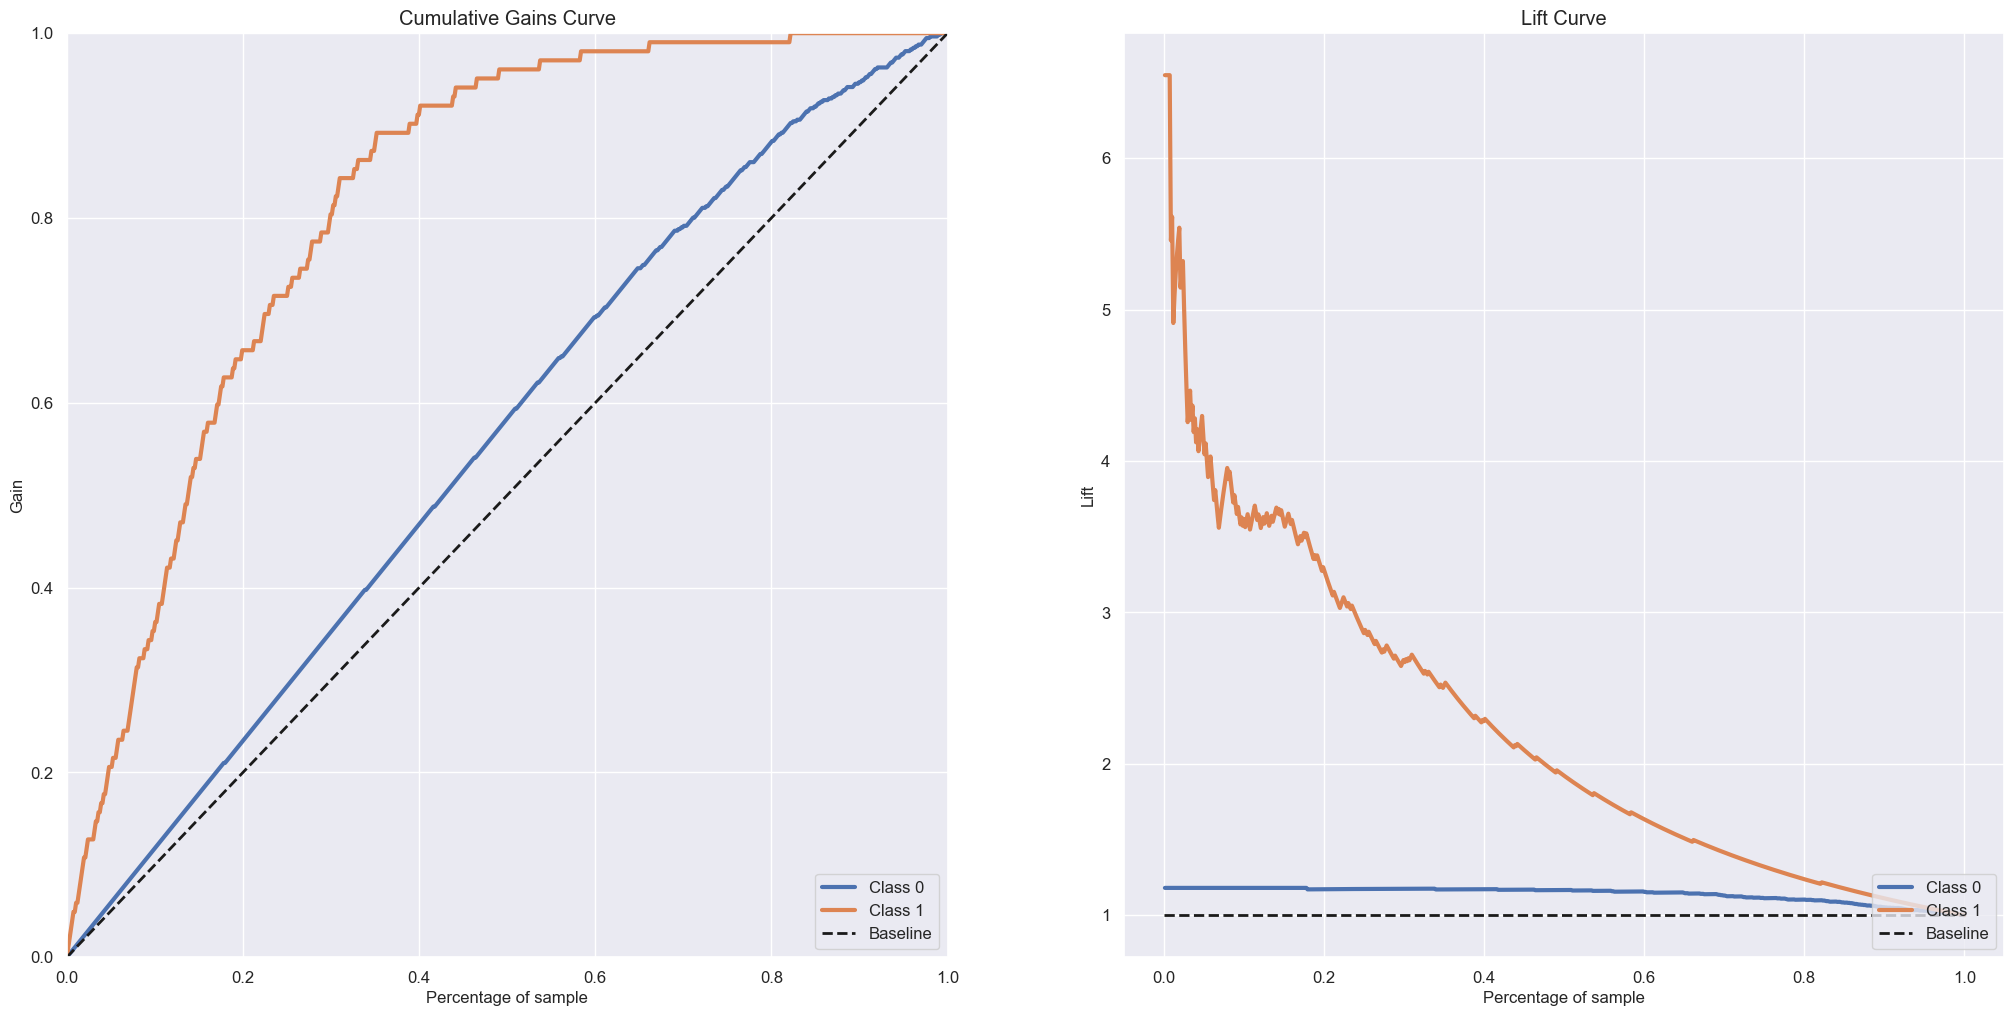

In [541]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_xgb_proba,ax=ax[1]);

# 8.0 Model performace 

Como estamos lidando com um dataset desbalanceado, temos um número de casos negativos "response == 0" em maior quantidade que de casos positivos "response == 1", logo, quando aplicamos o modelo no dataset de testes o número de falsos positivos é maior. Assim temos que ter cuidado com as metricas que estamos lidando pois podem ser influênciadas por esse desbalanceamento.

Para resolver isso utilizaremos a métrica *balanced accuracy score* - que calcula a média da razão de casos verdadeiros positivos e verdadeiros negativos, assim nos dando uma melhor ideia se o modelo está dividindo bem as classes.

Portanto, além das metrica de rankeamento(metrics at k) o balanced accuracy score será considerado na escolha do modelo.

In [542]:
clients = 300

## 8.1 KNN

In [543]:
knn_df = val.copy()

In [544]:
knn_df['score_knn'] = yhat_knn_proba[:,1].tolist()
# sorte by score
knn_df = knn_df.sort_values('score_knn',ascending=False)

In [545]:
knn_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_knn
547,2574,0.39,0.375099,0.272727,0.703282,0.060302,0.146341,0.000000,0.000000,0.074766,...,0,1,0.339286,3,0.735336,0.128563,0.486111,3,1,1.0
1967,3968,0.11,0.398190,0.777778,0.614869,0.050251,0.131098,0.050193,0.000000,0.401869,...,1,0,0.464286,1,0.523605,0.423104,0.473810,3,1,1.0
1791,3009,0.03,0.435310,0.080808,0.979236,0.080402,0.130081,0.000000,0.000000,0.498442,...,1,0,0.607143,1,0.507868,0.462105,0.698810,3,1,1.0
430,4947,0.22,0.546733,0.444444,0.405894,0.120603,0.989837,0.760618,0.740458,0.199377,...,0,1,0.535714,1,0.932761,0.579174,0.815079,2,1,1.0
500,4702,0.22,0.374122,0.202020,0.669792,0.778894,0.385163,0.864865,0.064885,0.373832,...,0,0,0.571429,1,0.981402,0.397815,0.750000,0,0,1.0


In [546]:
knn_performace = performace("KNN",knn_df,y_val,yhat_knn_class,clients)

In [547]:
knn_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,KNN,0.754879,0.661055,0.661055,300,0.272425,0.803922


## 8.2 Naive bayes

In [548]:
gnb_df = val.copy()

In [549]:
gnb_df['score_gnb'] = yhat_gnb_proba[:,1].tolist()
# sorte by score
gnb_df = gnb_df.sort_values('score_gnb',ascending=False)

In [550]:
gnb_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_gnb
1710,2186,0.25,0.501634,0.303030,0.628265,0.713568,0.766260,0.613900,0.309160,0.570093,...,1,1,0.339286,2,0.158798,0.262606,0.893651,3,1,1.0
405,3725,0.22,0.517437,0.010101,0.835901,0.080402,0.354675,0.166023,0.061069,0.049844,...,1,1,0.625000,1,0.595136,0.548393,0.667857,4,1,1.0
693,10430,0.11,0.547493,0.222222,0.754186,0.140704,0.214431,0.142857,0.106870,0.130841,...,1,1,0.410714,3,0.376252,0.188939,0.582143,3,0,1.0
807,4856,0.39,0.501765,0.383838,0.372405,0.271357,0.858740,0.779923,0.507634,0.196262,...,0,1,0.696429,2,0.858369,0.262675,0.733333,2,0,1.0
1232,5758,0.39,0.394848,0.232323,0.719357,0.000000,0.070122,0.000000,0.000000,0.143302,...,1,1,0.250000,2,0.237482,0.206507,0.469841,4,1,1.0


In [551]:
gnb_performace = performace("naive_bayers",gnb_df,y_val,yhat_gnb_class,clients)

In [552]:
gnb_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,naive_bayers,0.658489,0.723134,0.723134,300,0.265781,0.784314


## 8.3 Linear model

In [553]:
lm_df = val.copy()

In [554]:
lm_df['score_lm'] = yhat_lm_proba[:,1].tolist()
# sorte by score
lm_df = lm_df.sort_values('score_lm',ascending=False)

In [555]:
lm_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_lm
1688,7872,0.39,0.529704,0.070707,0.119893,0.105528,0.277439,0.000000,0.080153,0.196262,...,1,1,0.375000,2,0.937053,0.277352,0.219048,3,1,0.996259
405,3725,0.22,0.517437,0.010101,0.835901,0.080402,0.354675,0.166023,0.061069,0.049844,...,1,1,0.625000,1,0.595136,0.548393,0.667857,4,1,0.991006
1791,3009,0.03,0.435310,0.080808,0.979236,0.080402,0.130081,0.000000,0.000000,0.498442,...,1,0,0.607143,1,0.507868,0.462105,0.698810,3,1,0.952637
430,4947,0.22,0.546733,0.444444,0.405894,0.120603,0.989837,0.760618,0.740458,0.199377,...,0,1,0.535714,1,0.932761,0.579174,0.815079,2,1,0.951052
1009,3005,0.22,0.509115,0.070707,0.354990,0.587940,0.689024,0.517375,0.167939,0.457944,...,0,1,0.071429,1,0.084406,0.539649,0.652778,2,1,0.946155


In [556]:
lm_performace = performace("linear model",lm_df,y_val,yhat_lm_class,clients)

In [557]:
lm_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,linear model,0.818969,0.701552,0.701552,300,0.315615,0.931373


## 8.4 Balanced random forrest

In [558]:
brf_df = val.copy()

In [559]:
brf_df['score_brf'] = yhat_brf_proba[:,1].tolist()
#sort by score

brf_df = brf_df.sort_values('score_brf',ascending=False)

In [560]:
brf_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_brf
405,3725,0.22,0.517437,0.010101,0.835901,0.080402,0.354675,0.166023,0.061069,0.049844,...,1,1,0.625000,1,0.595136,0.548393,0.667857,4,1,0.94
1688,7872,0.39,0.529704,0.070707,0.119893,0.105528,0.277439,0.000000,0.080153,0.196262,...,1,1,0.375000,2,0.937053,0.277352,0.219048,3,1,0.93
1524,10352,0.03,0.202176,0.020202,0.033490,0.020101,0.028455,0.023166,0.011450,0.080997,...,0,0,0.589286,3,0.944206,0.068001,0.044444,0,1,0.92
1419,830,0.22,0.449837,0.050505,0.525117,0.241206,0.569106,0.162162,0.671756,0.149533,...,1,1,0.160714,1,0.178827,0.477368,0.655952,2,1,0.91
1586,1172,0.39,0.564901,0.717172,0.655727,0.221106,0.950203,0.111969,0.095420,0.068536,...,1,1,0.232143,2,0.606581,0.295843,0.805159,3,1,0.88


In [561]:
brf_performace = performace("balanced random forest",brf_df,y_val,yhat_brf_class,clients)

In [562]:
brf_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,balanced random forest,0.68234,0.807611,0.807611,300,0.318937,0.941176


## 8.5 Randon forrest

In [563]:
rf_df = val.copy()

In [564]:
rf_df['score_rf'] = yhat_rf_proba[:,1].tolist()
# sorte by score
rf_df = rf_df.sort_values('score_rf',ascending=False)

In [565]:
rf_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_rf
405,3725,0.22,0.517437,0.010101,0.835901,0.080402,0.354675,0.166023,0.061069,0.049844,...,1,1,0.625000,1,0.595136,0.548393,0.667857,4,1,0.843333
1688,7872,0.39,0.529704,0.070707,0.119893,0.105528,0.277439,0.000000,0.080153,0.196262,...,1,1,0.375000,2,0.937053,0.277352,0.219048,3,1,0.780000
1419,830,0.22,0.449837,0.050505,0.525117,0.241206,0.569106,0.162162,0.671756,0.149533,...,1,1,0.160714,1,0.178827,0.477368,0.655952,2,1,0.765333
1789,2109,0.22,0.591988,0.606061,0.300067,0.356784,0.966463,0.154440,0.064885,0.052960,...,1,0,0.107143,1,0.618026,0.626722,0.610714,1,1,0.740000
1009,3005,0.22,0.509115,0.070707,0.354990,0.587940,0.689024,0.517375,0.167939,0.457944,...,0,1,0.071429,1,0.084406,0.539649,0.652778,2,1,0.740000


In [566]:
rf_performace = performace("Random forest",rf_df,y_val,yhat_rf_class,clients)

In [567]:
rf_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,Random forest,0.772621,0.637827,0.637827,300,0.302326,0.892157


## 8.6 Extra trees

In [568]:
et_df = val.copy()

In [569]:
et_df['score_et'] = yhat_et_proba[:,1].tolist()
# sorte by score
et_df = et_df.sort_values('score_et',ascending=False)

In [570]:
et_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_et
76,535,0.11,0.495628,0.181818,0.109176,0.115578,0.430894,0.104247,0.248092,0.236760,...,0,0,0.160714,1,0.177396,0.525478,0.306746,0,0,1.0
179,7224,0.39,0.184375,0.242424,0.006698,0.000000,0.010163,0.011583,0.003817,0.021807,...,0,0,0.339286,4,0.260372,0.044681,0.010317,0,0,1.0
1331,8254,0.39,0.204560,0.484848,0.009377,0.000000,0.002033,0.000000,0.000000,0.021807,...,0,0,0.392857,3,0.632332,0.068836,0.007143,0,0,1.0
1681,9847,0.39,0.381173,0.393939,0.209645,0.075377,0.047764,0.077220,0.000000,0.598131,...,0,0,0.732143,3,0.994278,0.130690,0.230952,0,0,1.0
1580,10340,0.25,0.208294,0.686869,0.050234,0.060302,0.143293,0.166023,0.148855,0.582555,...,0,0,0.214286,3,0.848355,0.070144,0.195238,0,0,1.0


In [571]:
et_performace = performace("Extra trees",et_df,y_val,yhat_et_class,clients)

In [572]:
et_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,Extra trees,0.755223,0.644097,0.644097,300,0.299003,0.882353


## 8.7 XGboost

In [573]:
xgb_df = val.copy()

In [574]:
xgb_df['score_xgb'] = yhat_xgb_proba[:,1].tolist()
# sorte by score
xgb_df = xgb_df.sort_values('score_xgb',ascending=False)

In [575]:
xgb_df.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response,score_xgb
1688,7872,0.39,0.529704,0.070707,0.119893,0.105528,0.277439,0.000000,0.080153,0.196262,...,1,1,0.375000,2,0.937053,0.277352,0.219048,3,1,0.999966
1051,1524,0.22,0.497725,0.010101,0.474883,0.226131,0.116870,0.115830,0.610687,0.140187,...,0,1,0.232143,1,0.693848,0.527682,0.436111,1,1,0.999606
405,3725,0.22,0.517437,0.010101,0.835901,0.080402,0.354675,0.166023,0.061069,0.049844,...,1,1,0.625000,1,0.595136,0.548393,0.667857,4,1,0.997715
1419,830,0.22,0.449837,0.050505,0.525117,0.241206,0.569106,0.162162,0.671756,0.149533,...,1,1,0.160714,1,0.178827,0.477368,0.655952,2,1,0.997146
430,4947,0.22,0.546733,0.444444,0.405894,0.120603,0.989837,0.760618,0.740458,0.199377,...,0,1,0.535714,1,0.932761,0.579174,0.815079,2,1,0.996160


In [576]:
xgb_performace = performace("XGBoost",xgb_df,y_val,yhat_xgb_class,clients)

In [577]:
xgb_performace

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,XGBoost,0.71791,0.649969,0.649969,300,0.318937,0.941176


## 8.8 Model comparison

In [578]:
model_comp = pd.concat([knn_performace,lm_performace,rf_performace,et_performace,xgb_performace,gnb_performace,brf_performace])

In [579]:
model_comp.sort_values(by='Recall at k',ascending=False)

,Model Name,Precison,Recall,Balanced_acc,k,Precison at k,Recall at k
0,XGBoost,0.717910,0.649969,0.649969,300,0.318937,0.941176
0,balanced random forest,0.682340,0.807611,0.807611,300,0.318937,0.941176
0,linear model,0.818969,0.701552,0.701552,300,0.315615,0.931373
0,Random forest,0.772621,0.637827,0.637827,300,0.302326,0.892157
0,Extra trees,0.755223,0.644097,0.644097,300,0.299003,0.882353
0,KNN,0.754879,0.661055,0.661055,300,0.272425,0.803922
0,naive_bayers,0.658489,0.723134,0.723134,300,0.265781,0.784314


# 9.0 Cross validation

In [580]:
models = {
    'KNN': knn_model,
    'naive bayers': gnb_model,
    'Linear model': lm_model,
    'balanced random forrest': brf_model,
    'Random forrest': rf_model,
    'Extra trees': et_model,
    'XGBoost':xgb_model
}

In [581]:
models_comparison = pd.DataFrame()
for c, v in models.items():
    aux = performace_cross_val(df6,'response',v,c,k=300)
    models_comparison = pd.concat([models_comparison,aux])

In [582]:
models_comparison

,model name,precision_cv,prec_std,recall_cv,rec_std,balanced_acc_cv,bal_std,k,precision_at_k_cv,perc_k_std,recall_at_k_cv,rec_k_std
0,KNN CV,0.7615,0.0374,0.6552,0.0102,0.6552,0.0102,300,0.2724,0.0098,0.7934,0.0
0,naive bayers CV,0.6662,0.0195,0.7223,0.0266,0.7223,0.0266,300,0.2602,0.0234,0.7580,0.0
0,Linear model CV,0.8370,0.0058,0.6999,0.0068,0.6999,0.0068,300,0.3167,0.0103,0.9225,0.0
0,balanced random forrest CV,0.6742,0.0118,0.7916,0.0226,0.7916,0.0226,300,0.3178,0.0095,0.9258,0.0
0,Random forrest CV,0.7890,0.0540,0.6428,0.0243,0.6428,0.0243,300,0.3068,0.0083,0.8935,0.0
0,Extra trees CV,0.7824,0.0458,0.6409,0.0243,0.6409,0.0243,300,0.3012,0.0041,0.8774,0.0
0,XGBoost CV,0.7663,0.0128,0.7152,0.0256,0.7152,0.0256,300,0.3123,0.0094,0.9096,0.0


**O modelo escolhido será o balanced ramdom forrest**